No samples were excluded


<Figure size 800x600 with 0 Axes>

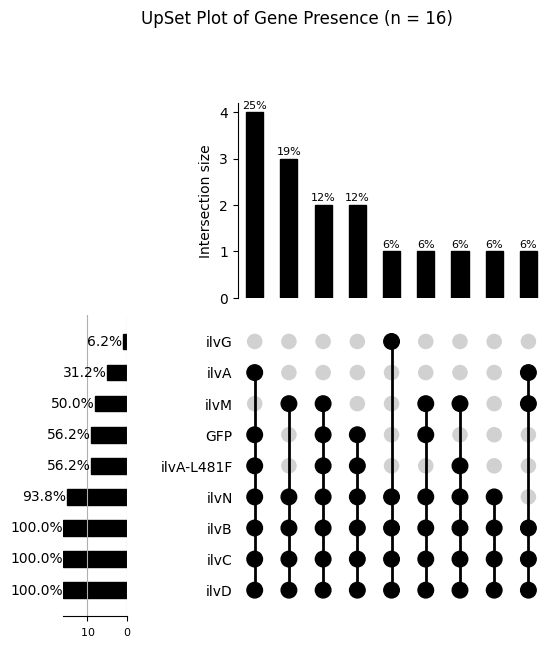

Figure saved to: /Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/CHO_Valine/CHO_Valine_SummaryOutputs/UpSet_CHO_Val_All_Proto.svg
Number of samples included in UpSet plot: 16


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import FixedLocator
from upsetplot import UpSet, from_indicators
import warnings
import os

warnings.simplefilter("ignore", category=FutureWarning)

# Load and preprocess data
file_path = "/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/CHO_Valine/CHO_Valine_SummaryOutputs/CHO_Val_Zscore_Summary_InclValScore.csv"
data = pd.read_csv(file_path)
val_metrics = data.iloc[:, -1:]
binary_data = data.iloc[:, :-1].copy()
binary_data.iloc[:, 1:] = (binary_data.iloc[:, 1:] > 1.15).astype(int)

# Group gene columns
gene_map = {
    g: [f"{g}__{p}" for p in ["Ef1a", "PGK", "Ef1a-MTS", "PGK-MTS"]] for g in [
        "GFP", "ilvA", "ilvA mut 1", "ilvA mut 2", "ilvG", "ilvM", "ilvB", "ilvN", "ilvC", "ilvD"]
}

# Sum across gene groups
for gene, cols in gene_map.items():
    binary_data[gene] = binary_data[[c for c in cols if c in binary_data.columns]].sum(axis=1)

# Save summed binary presence
summed_df = pd.concat([binary_data, val_metrics], axis=1)
output_csv = "summed_gene_presence_CHO_Val.csv"
summed_df.to_csv(output_csv, index=False)

# Reload for visualization
data = pd.read_csv(output_csv)

# Filter based on thresholds
val_thresh = 0.23
filtered = data[data["Val score"] > val_thresh] if "Val score" in data.columns else data

# Rename mutation columns for plotting
rename_map = {
    "ilvA mut 1": "ilvA-L447F",
    "ilvA mut 2": "ilvA-L481F"
}
filtered = filtered.rename(columns=rename_map)

# Choose genes for plot (with updated names)
genes = ["ilvD", "ilvC", "ilvB", "ilvN", "ilvG", "ilvM", "ilvA", "ilvA-L447F", "ilvA-L481F", "GFP"]
existing = [g for g in genes if g in filtered.columns]
upset_data = pd.DataFrame({g: (filtered[g] >= 1) for g in existing})

# Filter out all-zero rows
excluded = filtered.loc[upset_data.sum(axis=1) == 0, "File"].tolist() if "File" in filtered.columns else []
upset_data = upset_data[upset_data.sum(axis=1) > 0]

if excluded:
    print("Excluded samples:", *excluded, sep="\n- ")
else:
    print("No samples were excluded")

# Generate UpSet data
upset_df = from_indicators(upset_data.columns, upset_data)

# Plot
plt.figure(figsize=(8, 6))
up = UpSet(upset_df, sort_by="cardinality", show_percentages=True, shading_color='white')
up.plot()

# Italicize gene names using LaTeX-style formatting
for ax in plt.gcf().axes:
    if ax.get_xticklabels():
        tick_labels = [label.get_text() for label in ax.get_xticklabels()]
        tick_positions = ax.get_xticks()
        ax.xaxis.set_major_locator(FixedLocator(tick_positions))
        ax.set_xticklabels([rf"$\it{{{label}}}$" for label in tick_labels], fontsize=8)

# Format % labels
for text in plt.gca().texts:
    try:
        pct = float(text.get_text().replace('%', ''))
        text.set_text(f"{round(pct)}%")
        text.set_fontsize(8)
    except ValueError:
        pass

# Clean up plot
for ax in plt.gcf().axes:
    if ax.get_ylabel():
        ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.grid(False)

# Save output
output_path = "/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/CHO_Valine/CHO_Valine_SummaryOutputs/UpSet_CHO_Val_All_Proto.svg"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.suptitle(f"UpSet Plot of Gene Presence (n = {len(filtered)})", fontsize=12, y=1.02)
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Figure saved to: {output_path}")
print(f"Number of samples included in UpSet plot: {len(filtered)}")
